# Librerie 

In [21]:
#Base
import os
import pandas as pd
import numpy as np
import scipy as sp
import time
import sys
import matplotlib as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import (
    accuracy_score,      
    precision_score,     
    recall_score,        
    confusion_matrix,       
    f1_score             
)


sys.path.insert(1,'../Data') 
from preprocessing_v3 import preprocessing_diabetes_v3,combination_features

#Set the random seed for reproducibility
import random
random.seed(42)
np.random.seed(42) 




# Funzioni

In [10]:
from sklearn import metrics


def knn_grid_search(X_train_in, y_train_in, max_neighbors=5, num_partizioni=10, modelName='Name'):
    KNN = KNeighborsClassifier() 
    #Grid space

    search_space = {
    'n_neighbors': list(range(1, max_neighbors + 1)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

    #Grid search with cross-validation
    grid_search = GridSearchCV(
    KNN,
    param_grid = search_space,
    scoring = { "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
                "f1": "f1" },
        refit='f1',
    cv= num_partizioni,
    )
    
    grid_search.fit(X_train_in, y_train_in)
    
   
    best_index = grid_search.best_index_

    mean_accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
    mean_precision = grid_search.cv_results_['mean_test_precision'][best_index]
    mean_recall = grid_search.cv_results_['mean_test_recall'][best_index]
    mean_f1 = grid_search.cv_results_['mean_test_f1'][best_index]


    Performance_best_model = pd.DataFrame(
        [[mean_accuracy, mean_precision, mean_recall, mean_f1]],
        columns=['Accuracy', 'Precision', 'Recall', 'F1'],
        index=[modelName]
    )

    
    Parameter_Best = grid_search.best_params_  
    Parameter_Best= pd.DataFrame(Parameter_Best, index=[modelName])
    
    Featurces_Best_df= pd.concat([ Performance_best_model, Parameter_Best], axis=1)
    display(Featurces_Best_df)

    KNN_Best= grid_search.best_estimator_
    
    return KNN_Best, Featurces_Best_df


def evaluate_knn(knn_model, X_test, y_test, label='Test'):
    
    y_pred = knn_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)      
    precision = precision_score(y_test, y_pred)     
    recall = recall_score(y_test, y_pred)           
    f1 = f1_score(y_test, y_pred)                   

    metrics_df = pd.DataFrame(
    data=[[accuracy, precision, recall, f1]],   
    columns=['Accuracy', 'Precision', 'Recall', 'f1'],  
    index=[label]                               
    )

    conf_mat=confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(conf_mat,
                        index=['sani', 'diabetici'],
                        columns=['sani', 'diabetici']

            )
    return metrics_df, cm_df, 




# Importazione dati

In [11]:
train_data= pd.read_csv('../Data/diabetes_train.csv')
test_data= pd.read_csv('../Data/diabetes_test.csv')

# KNN con diversi Preprocessing

### without oversampling and new features


In [12]:
#Normal 
X_train_norm, X_test_norm, y_train_norm, y_test_norm = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=False)
knn_best_norm, performance_train_df_norm = knn_grid_search(X_train_norm, y_train_norm, max_neighbors=15, num_partizioni=10, modelName='Normal')

# PCA
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = preprocessing_diabetes_v3(train_data, test_data, option='PCA', augment=False, oversample=False, delete_smoking=False)
knn_best_PCA, performance_train_df_PCA = knn_grid_search(X_train_PCA, y_train_PCA, max_neighbors=15, num_partizioni=10, modelName='PCA')

#No Correlation
X_train_noCorr, X_test_noCorr, y_train_noCorr, y_test_noCorr = preprocessing_diabetes_v3(train_data, test_data, option='Delete', augment=False, oversample=False, delete_smoking=False)
knn_best_noCorr, performance_train_df_noCorr = knn_grid_search(X_train_noCorr, y_train_noCorr, max_neighbors=15, num_partizioni=10 , modelName='No_Correlation')


#No Smoking
X_train_NoSmok, X_test_NoSmok, y_train_NoSmok, y_test_NoSmok = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=False, delete_smoking=True)
knn_best_NoSmok, performance_train_df_NoSmok = knn_grid_search(X_train_NoSmok, y_train_NoSmok, max_neighbors=15, num_partizioni=10, modelName='No_Smoking')

Performance_all = pd.concat([performance_train_df_norm, performance_train_df_PCA, performance_train_df_noCorr, performance_train_df_NoSmok], axis=0)

,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
Normal,0.969229,0.942917,0.938571,0.937319,manhattan,12,distance


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
PCA,0.965839,0.960298,0.904286,0.927443,euclidean,2,uniform


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
No_Correlation,0.965809,0.922183,0.951905,0.932943,manhattan,5,distance


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
No_Smoking,0.965868,0.925833,0.945238,0.932658,manhattan,4,distance


### with oversampling and new features

In [13]:
#PCA
X_train_PCA_OverAug, X_test_PCA_OverAug, y_train_PCA_OverAug, y_test_PCA_OverAug = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=True, oversample=True, delete_smoking=False)
knn_best_PCA_OverAug, performance_train_df_PCA_OverAug = knn_grid_search(X_train_PCA_OverAug, y_train_PCA_OverAug, max_neighbors=15, num_partizioni=10, modelName='PCA - Overs. + Aug')


#No Smoking
X_train_PCA_noSmok_OverAug, X_test_PCA_noSmok_OverAug, y_train_PCA_noSmok_OverAug, y_test_PCA_noSmok_OverAug = preprocessing_diabetes_v3(train_data, test_data, option='PCA', augment=True, oversample=True, delete_smoking=True)
knn_best_PCA_noSmok_OverAug, performance_train_df_PCA_noSmok_OverAug = knn_grid_search(X_train_PCA_noSmok_OverAug, y_train_PCA_noSmok_OverAug, max_neighbors=15, num_partizioni=10 , modelName='No Smok + PCA - Overs. + Aug')

Performance_all = pd.concat([Performance_all, performance_train_df_PCA_OverAug, performance_train_df_PCA_noSmok_OverAug], axis=0)

,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
PCA - Overs. + Aug,0.973851,0.957257,0.993182,0.974595,euclidean,1,uniform


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
No Smok + PCA - Overs. + Aug,0.973838,0.969711,0.979493,0.974182,manhattan,2,uniform


### with only oversampling

In [14]:
#Normal
X_train_Norm_Over, X_test_Norm_Over, y_train_Norm_Over, y_test_Norm_Over = preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=False) 
knn_best_Norm_Over, performance_train_df_Norm_Over = knn_grid_search(X_train_Norm_Over, y_train_Norm_Over, max_neighbors=15, num_partizioni=10 , modelName='Normal - Oversampling')


# PCA
X_train_PCA_Over, X_test_PCA_Over, y_train_PCA_Over, y_test_PCA_Over = preprocessing_diabetes_v3(train_data, test_data, option='PCA',augment=False, oversample=True, delete_smoking=False)
knn_best_PCA_Over, performance_train_df_PCA_Over = knn_grid_search(X_train_PCA_Over, y_train_PCA_Over, max_neighbors=15, num_partizioni=10 , modelName='PCA - Oversampling')


#No Correlation
X_train_noCorr_Over, X_test_noCorr_Over, y_train_noCorr_Over, y_test_noCorr_Over = preprocessing_diabetes_v3(train_data, test_data, option='Delete',augment=False, oversample=True, delete_smoking=False)
knn_best_noCorr_Over, performance_train_df_noCorr_Over = knn_grid_search(X_train_noCorr_Over, y_train_noCorr_Over, max_neighbors=15, num_partizioni=10 , modelName='No_Correlation - Oversampling')


#No Smoking
X_train_NoSmok_Over, X_test_NoSmok_Over, y_train_NoSmok_Over, y_test_NoSmok_Over= preprocessing_diabetes_v3(train_data, test_data, augment=False, oversample=True, delete_smoking=True)
knn_best_NoSmok_Over, performance_train_df_NoSmok_Over = knn_grid_search(X_train_NoSmok_Over, y_train_NoSmok_Over, max_neighbors=15, num_partizioni=10, modelName='No_Smoking - Oversampling')

Performance_all = pd.concat([Performance_all, performance_train_df_Norm_Over, performance_train_df_PCA_Over, performance_train_df_noCorr_Over, performance_train_df_NoSmok_Over], axis=0)

,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
Normal - Oversampling,0.980669,0.969315,0.993182,0.980997,manhattan,2,uniform


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
PCA - Oversampling,0.971565,0.966834,0.977273,0.971802,manhattan,2,uniform


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
No_Correlation - Oversampling,0.974987,0.96704,0.984091,0.975301,manhattan,2,uniform


,Accuracy,Precision,Recall,F1,metric,n_neighbors,weights
No_Smoking - Oversampling,0.973824,0.967638,0.981765,0.974242,manhattan,2,uniform


# Risultati 

PERFORMANCE Sul Test

In [15]:
Performance_all = Performance_all.sort_values(by='F1', ascending=False)
Performance_all = Performance_all.drop(columns=['Accuracy', 'Precision', 'Recall'])
display(Performance_all)

,F1,metric,n_neighbors,weights
Normal - Oversampling,0.980997,manhattan,2,uniform
No_Correlation - Oversampling,0.975301,manhattan,2,uniform
PCA - Overs. + Aug,0.974595,euclidean,1,uniform
No_Smoking - Oversampling,0.974242,manhattan,2,uniform
No Smok + PCA - Overs. + Aug,0.974182,manhattan,2,uniform
PCA - Oversampling,0.971802,manhattan,2,uniform
Normal,0.937319,manhattan,12,distance
No_Correlation,0.932943,manhattan,5,distance
No_Smoking,0.932658,manhattan,4,distance
PCA,0.927443,euclidean,2,uniform


Test sul modello con F1 più alta 

,Accuracy,Precision,Recall,f1
Normal - Oversampling,0.959184,0.878049,0.972973,0.923077


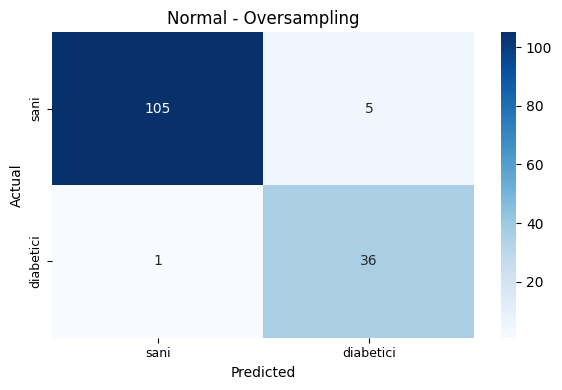

In [16]:
metrics_df_Norm_Over, conf_mat_Norm_Over = evaluate_knn(knn_best_Norm_Over, X_test_Norm_Over, y_test_Norm_Over, label='Normal - Oversampling')

display(metrics_df_Norm_Over)

# MATRICE DI CONFUSIONE
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4))
sns.heatmap(conf_mat_Norm_Over, annot=True, fmt='d', cmap='Blues', ax=ax2, annot_kws={"size": 10})
ax2.set_title('Normal - Oversampling', fontsize=12)
ax2.set_xlabel('Predicted', fontsize=10)
ax2.set_ylabel('Actual', fontsize=10)
ax2.tick_params(axis='both', labelsize=9)
plt.tight_layout()
plt.show()